# Assignment4. CIFAR-10 Classification with CNN

Lab7에서는 assignment3-CIFAR-10 Classification with MLP 코드의 MLP로 정의된 model arcitecture 부분을 수정하여 CNN으로 바꾸고, 이를 통해 CIFAR-10 dataset의 10-way classification을 CNN을 통해 해보았습니다. 그 과정에서 MLP에서 그러했듯, 다양한 hyperparameter들을 변수화하여 CNN model을 customize할 수 있게하였고, 그 결과 hyperparameter tunning 없이도 test accuracy 73%를 얻어낼 수 있었습니다. 그러나 loss graph 상에서 train / validation loss가 벌어지는 overfitting 현상 또한 볼 수 있었습니다.

본 과제에서는 kernel size등 더 다양한 hyperparamteter들을 변수화하여 control할 수 있게하고, l2 regularization, fully connected layer의 dropout 등 다양한 tecnique들을 적용해 CNN 모델의 성능을 더 높여보도록 합시다.


### 실험을 완료하신 뒤에는
주피터 노트북 파일의 끝 부분에 최종적으로 최적화한 hyperparameter set과 그에 따른 test/validation/train accuracy를 리포트해 주신 뒤 github 링크를 [과제 제출 및 피드백 링크](https://goo.gl/forms/LpHtAMinhIYiiKCY2) 를 통해 제출해주시면 감사하겠습니다.

<hr>  

# 시작하기

[제가 미리 만들어놓은 이 링크](https://colab.research.google.com/github/heartcored98/Standalone-DeepLearning/blob/master/Lec5/Assignment4_CIFAR-10_with_CNN.ipynb)를 통해 Colab에서 바로 작업하실 수 있습니다!  
만약 코드가 알록달록 하지 않다면(Syntax Highlighting이 안 된다면)  
그냥 새로운 python3, GPU 런타임으로 Colab 파일을 만드신 후 코드를 복붙하시는게 빠를 겁니다.   

<hr>

아래 코드를 통해 Colab에 연결되어 있는 서버 컴퓨터 내에 결과들을 저장할 results 폴더를 만들어봅시다.  
만약 이미 만들었다면 **File exists** 와 같은 에러가 뜨면서 새로운 폴더 생성이 불가능할텐데 폴더만 있다면 괜찮으니 넘어가줍시다.  

In [ ]:
!mkdir assignment4 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
import seaborn as sns 
import matplotlib.pyplot as plt

## Data Preparation

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


## Model Architecture

In [3]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

In [4]:
class CNN(nn.Module):
    
    def __init__(self, model_code, in_channels, hid_dim, use_bn):
        super(CNN, self).__init__()
        
        self.layers = self._make_layers(model_code, in_channels, use_bn)
        self.classifier = nn.Sequential(nn.Linear(512, hid_dim),
                                        nn.ReLU(),
                                        nn.Linear(hid_dim, 10))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self, model_code, in_channels, use_bn):
        layers = nn.ModuleList()
        for x in cfg[model_code]:
            if x != 'M':
                layers.append(nn.Conv2d(in_channels=in_channels,
                                        out_channels=x,
                                        kernel_size=3,
                                        stride=1,
                                        padding=1))
                if use_bn:
                    layers.append(nn.BatchNorm2d(x))
                layers.append(nn.ReLU())
                in_channels = x
            else:
                layers.append(nn.MaxPool2d(kernel_size=2,
                                           stride=2))
        return layers

In [6]:
def dimesion_check():
    net = CNN('VGG19', 3, 256, True)
    x = torch.randn(2, 3, 32, 32)
    y = net(x)
    print(y.shape)

In [7]:
dimesion_check()

torch.Size([2, 10])


## Train, Validate, Test and Experiment

In [8]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()
    optimizer.zero_grad()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [9]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [10]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [11]:
def experiment(partition, args):
  
    net = CNN(args.model_code, args.in_channels, args.hid_dim, args.use_bn)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# Manage Experiment Result

In [12]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/Assignment4/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results/Assignment4'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

# Visualization Utility

In [13]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

## Experiment1. Learning Rate vs l2 regularization

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"


# ====== Additional Entities ====== #
args.model_code = 'VGG19'
args.in_channels = 3
args.hid_dim = 256
args.use_bn = False


# ====== Model Capacity ====== #
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.00001

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'l2'
list_var1 = [0.001, 0.0001, 0.00001]
list_var2 = [0.0001, 0.00001]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

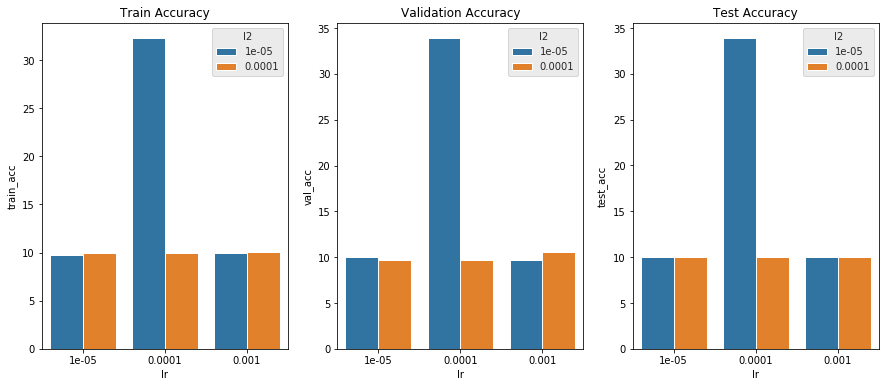

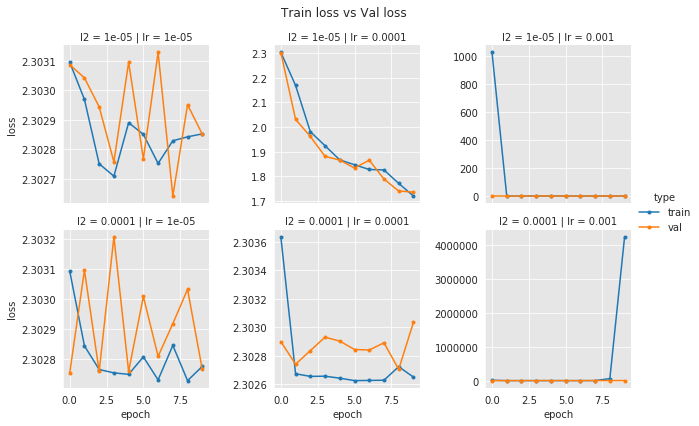

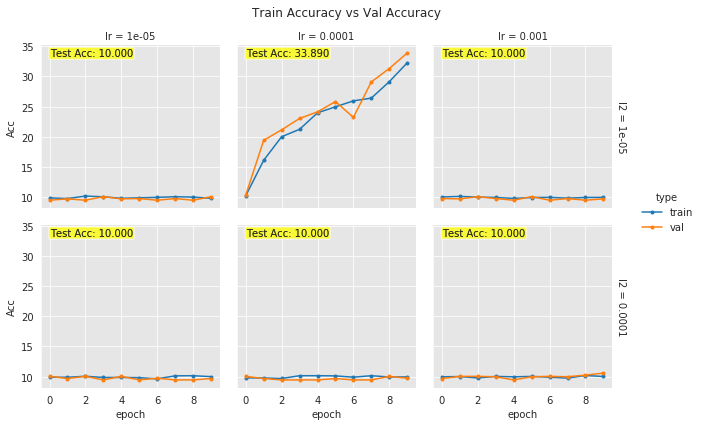

In [15]:
var1 = 'lr'
var2 = 'l2'
df = load_exp_result('exp1')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

From this experiment we found l2 = 1e-05 and lr = 0.0001

## Experiment2. Sample Exp

In [16]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_Sample"

# ====== Additional Entities ====== #
args.model_code = 'VGG19'
args.in_channels = 3
args.hid_dim = 256
args.use_bn = False

# ====== Model Capacity ====== #
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.00001

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 20

args.train_batch_size = 512
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'model_code'
name_var2 = 'hid_dim'
list_var1 = ['VGG11', 'VGG13']
list_var2 = [256]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', epoch=20, exp_name='exp2_Sample', hid_dim=256, in_channels=3, l2=1e-05, lr=0.0001, model_code='VGG11', optim='RMSprop', test_batch_size=1024, train_batch_size=512, use_bn=False)


KeyboardInterrupt: 

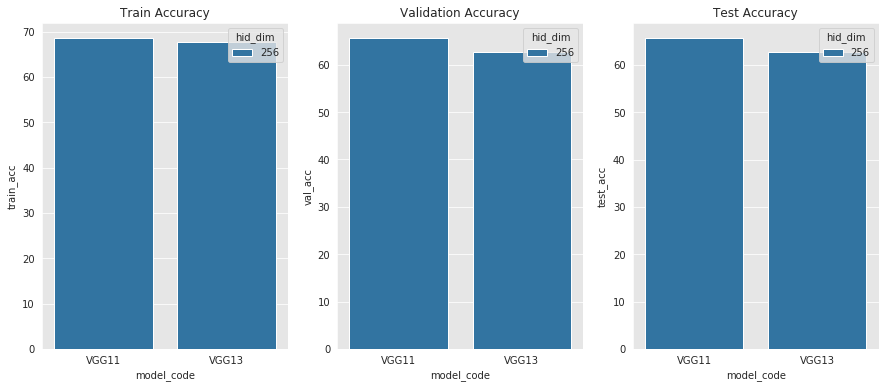

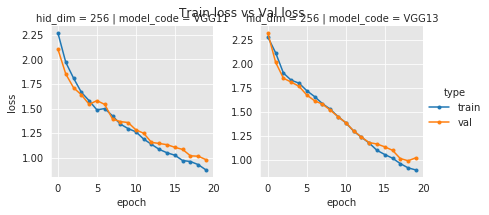

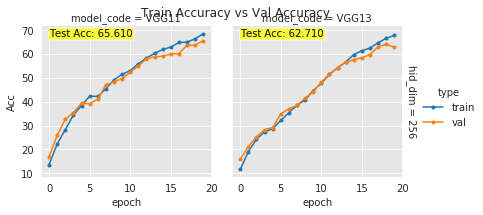

In [17]:
var1 = 'model_code'
var2 = 'hid_dim'
df = load_exp_result('exp2_Sample')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모둔 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True) #margin_titles를 True로 하면 그래프의 가장자리에 var1과 var2 값이 표시되고 False로 하면 각 subplot 위에 표시됩니다.

## Experiment3. Model_code vs hid_dim

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp3_modelcode_hiddim"

# ====== Additional Entities ====== #
args.model_code = 'VGG19'
args.in_channels = 3
args.hid_dim = 256
args.use_bn = False

# ====== Model Capacity ====== #
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.00001

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 25

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'model_code'
name_var2 = 'hid_dim'
list_var1 = ['VGG11', 'VGG13','VGG16','VGG19']
list_var2 = [256, 512]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

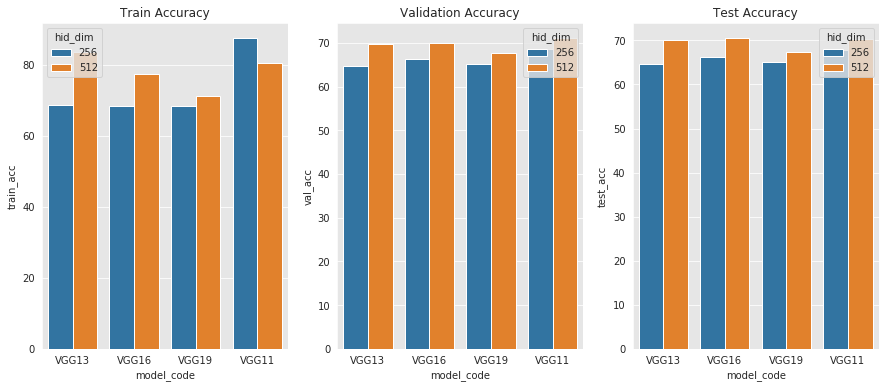

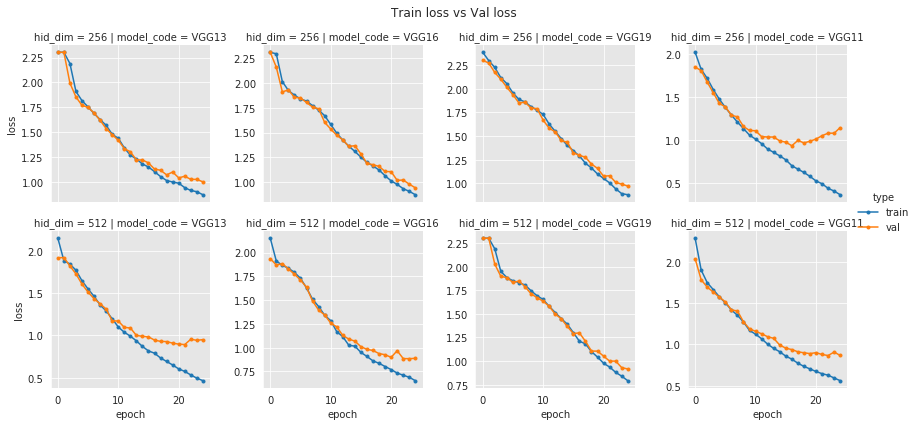

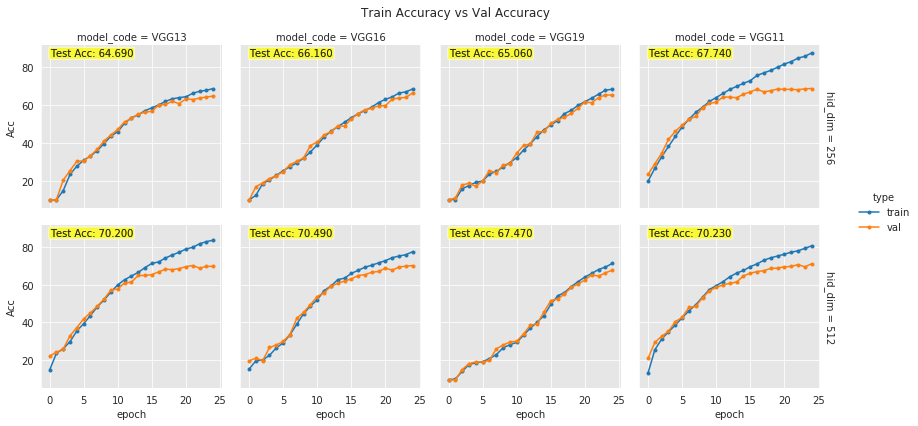

In [18]:
var1 = 'model_code'
var2 = 'hid_dim'
df = load_exp_result('exp3_modelcode_hiddim')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False)
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)

## Experiment4. VGG vs use_bn

In [20]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp4_VGG_in_channels"

# ====== Additional Entities ====== #
args.model_code = 'VGG19'
args.in_channels = 3
args.hid_dim = 512
args.use_bn = False

# ====== Model Capacity ====== #
args.act = 'relu'

# ====== Regularization ======= #
args.l2 = 0.00001

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 40

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'model_code'
name_var2 = 'use_bn'
list_var1 = ['VGG16','VGG19']
list_var2 = [True, False]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', epoch=40, exp_name='exp4_VGG_in_channels', hid_dim=512, in_channels=3, l2=1e-05, lr=0.0001, model_code='VGG16', optim='RMSprop', test_batch_size=1024, train_batch_size=256, use_bn=True)
Epoch 0, Acc(train/val): 25.31/24.39, Loss(train/val) 1.85/2.11. Took 35.43 sec
Epoch 1, Acc(train/val): 32.41/33.32, Loss(train/val) 1.68/1.64. Took 36.03 sec
Epoch 2, Acc(train/val): 36.74/37.93, Loss(train/val) 1.56/1.49. Took 35.29 sec
Epoch 3, Acc(train/val): 43.35/45.51, Loss(train/val) 1.39/1.38. Took 35.66 sec
Epoch 4, Acc(train/val): 50.87/50.69, Loss(train/val) 1.24/1.25. Took 35.57 sec
Epoch 5, Acc(train/val): 57.76/58.65, Loss(train/val) 1.12/1.16. Took 35.37 sec
Epoch 6, Acc(train/val): 63.88/63.47, Loss(train/val) 1.00/1.03. Took 35.36 sec
Epoch 7, Acc(train/val): 67.51/63.21, Loss(train/val) 0.91/1.10. Took 35.76 sec
Epoch 8, Acc(train/val): 70.00/66.63, Loss(train/val) 0.85/0.99. Took 35.74 sec
Epoch 9, Acc(train/val): 73.88/70.35, Loss(train/val) 0.76/0.88. Took 35

Epoch 14, Acc(train/val): 78.85/73.76, Loss(train/val) 0.64/0.82. Took 43.86 sec
Epoch 15, Acc(train/val): 81.04/72.62, Loss(train/val) 0.58/0.87. Took 43.82 sec
Epoch 16, Acc(train/val): 82.74/71.14, Loss(train/val) 0.54/0.94. Took 43.70 sec
Epoch 17, Acc(train/val): 83.62/71.28, Loss(train/val) 0.51/0.96. Took 44.16 sec
Epoch 18, Acc(train/val): 85.06/76.43, Loss(train/val) 0.47/0.77. Took 43.84 sec
Epoch 19, Acc(train/val): 85.98/75.43, Loss(train/val) 0.44/0.83. Took 43.77 sec
Epoch 20, Acc(train/val): 87.47/77.70, Loss(train/val) 0.40/0.74. Took 43.75 sec
Epoch 21, Acc(train/val): 88.66/77.62, Loss(train/val) 0.36/0.76. Took 43.77 sec
Epoch 22, Acc(train/val): 89.64/79.44, Loss(train/val) 0.32/0.69. Took 43.84 sec
Epoch 23, Acc(train/val): 90.34/79.19, Loss(train/val) 0.30/0.69. Took 43.77 sec
Epoch 24, Acc(train/val): 91.97/78.90, Loss(train/val) 0.26/0.76. Took 43.74 sec
Epoch 25, Acc(train/val): 91.98/79.98, Loss(train/val) 0.25/0.69. Took 43.80 sec
Epoch 26, Acc(train/val): 92

Traceback (most recent call last):
  File "/home/hemistone/.conda/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/hemistone/.conda/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/hemistone/.conda/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/hemistone/.conda/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/hemistone/.conda/envs/pytorch/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/hemistone/.conda/envs/pytorch/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/hemistone/.conda/env

KeyboardInterrupt: 

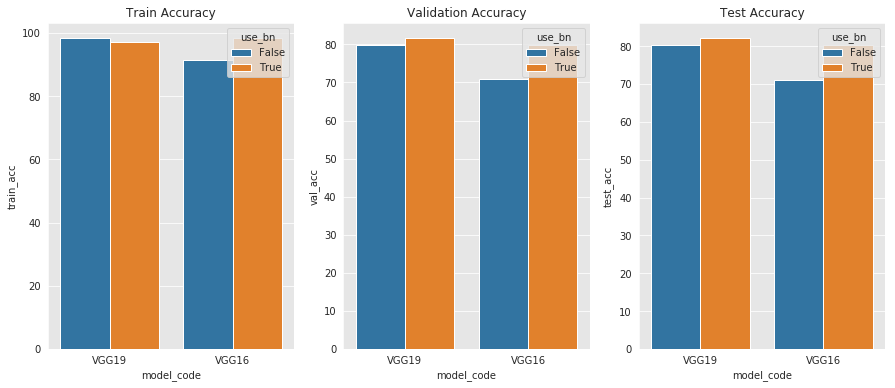

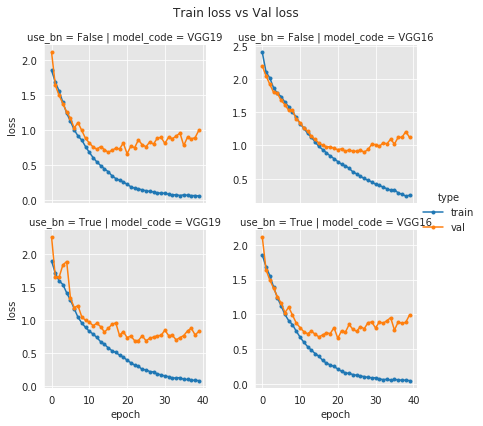

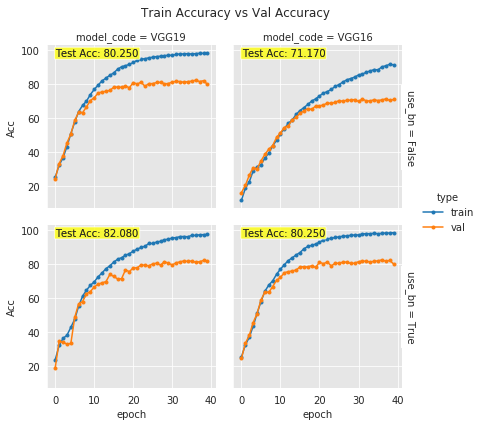

In [25]:
var1 = 'model_code'
var2 = 'use_bn'
df = load_exp_result('exp4_VGG')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False)
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)

Final max acc = 82.08%